<a href="https://colab.research.google.com/github/eagle034/ray_tracer_colab_practice/blob/main/Copy_of_Ray_Tracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray Tracer in Colab

This is a Colab setup to build and run a C++ ray tracer implementation forked from https://raytracing.github.io/. A thin Python/Cython layer is created to run the C++ code, and display the rendered image in the notebook. This allows both the high performance from C++ code and the flexibility of Python/Colab, but at the cost of requiring some Cython code to interface between them.

## Directory structure

The C++ sources are stored in the [`ray_tracer_colab`](https://github.com/artoowang/ray_tracer_colab) repo, and it will be checked out to the working directory of the Colab runtime in the initialization cell below.

When running the Colab runtime locally, it is also possible to manually check out the `ray_tracer_colab` repo under exactly that name. If such directory exists, initialization will use that directory and skip the checking out. This allows changing the C++ code locally (e.g., in a terminal) and rebuild the Cython module in this notebook to pick up the changes, which is useful for development.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Initialization

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image

%reload_ext Cython

imageio.plugins.freeimage.download()

In [ ]:
if os.path.exists('ray_tracer_colab'):
  print('Use local ray_tracer_colab repo.')
else:
  print('Checking out ray_tracer_colab repo ...')
  !git clone https://github.com/artoowang/ray_tracer_colab.git

Checking out ray_tracer_colab repo ...
Cloning into 'ray_tracer_colab'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 2.65 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
%ls

create_scene.cc   __init__.py            ray_tracer_colab/   src/
create_scene.h    libray_tracer_colab.a  ray_tracer_colab.o  utils/
create_scene.pxd  LICENSE                Ray_Tracer.ipynb
include/          pxd/                   README.md


In [ ]:
# Generate platform dependent cython arguments.
if sys.platform == 'darwin':
  cython_sys_dep_args = [
      '-c=-Wno-unreachable-code',
      '-c=-Wp,-fopenmp',
      '--link-args=-Wp,-fopenmp',
      '--link-args=-lomp',
  ]
else:
  cython_sys_dep_args = [
      '-c=-fopenmp',
      '--link-args=-fopenmp',
  ]

## ray_tracer_colab library

This contains all of the C++ sources for the ray tracer. If the C++ sources are modified, run this cell again to update `libray_tracer_colab.a`.

In [ ]:
!g++ -O3 -fPIC -Iray_tracer_colab/include -std=c++17 -c ray_tracer_colab/src/scene.cc -o ray_tracer_colab.o
!ar rcs libray_tracer_colab.a ray_tracer_colab.o

### create_scene.h

In [ ]:
%%file create_scene.h

#ifndef CREATE_SCENE_H
#define CREATE_SCENE_H

#include <memory>

#include "hittable.h"
#include "hittable_list.h"

hittable_list CreateRandomWorld();
std::unique_ptr<hittable> CreateSphere();

#endif  // CREATE_SCENE_H

Writing create_scene.h


### create_scene.cc

In [ ]:
%%file create_scene.cc

#include "create_scene.h"

#include <utility>

#include "color.h"
#include "hittable_list.h"
#include "material.h"
#include "rtweekend.h"
#include "sphere.h"

hittable_list CreateRandomWorld() {
    hittable_list world;

    auto ground_material = make_shared<lambertian>(color(0.5, 0.5, 0.5));
    world.add(std::make_unique<sphere>(point3(0,-1000,0), 1000, ground_material));

    for (int a = -11; a < 11; a++) {
        for (int b = -11; b < 11; b++) {
            auto choose_mat = random_double();
            point3 center(a + 0.9*random_double(), 0.2, b + 0.9*random_double());

            if ((center - point3(4, 0.2, 0)).length() > 0.9) {
                shared_ptr<material> sphere_material;

                if (choose_mat < 0.8) {
                    // diffuse
                    auto albedo = color::random() * color::random();
                    sphere_material = make_shared<lambertian>(albedo);
                    world.add(std::make_unique<sphere>(center, 0.2, sphere_material));
                } else if (choose_mat < 0.95) {
                    // metal
                    auto albedo = color::random(0.5, 1);
                    auto fuzz = random_double(0, 0.5);
                    sphere_material = make_shared<metal>(albedo, fuzz);
                    world.add(std::make_unique<sphere>(center, 0.2, sphere_material));
                } else {
                    // glass
                    sphere_material = make_shared<dielectric>(1.5);
                    world.add(std::make_unique<sphere>(center, 0.2, sphere_material));
                }
            }
        }
    }

    auto material1 = make_shared<dielectric>(1.5);
    world.add(std::make_unique<sphere>(point3(0, 1, 0), 1.0, material1));

    auto material2 = make_shared<lambertian>(color(0.4, 0.2, 0.1));
    world.add(std::make_unique<sphere>(point3(-4, 1, 0), 1.0, material2));

    auto material3 = make_shared<metal>(color(0.7, 0.6, 0.5), 0.0);
    world.add(std::make_unique<sphere>(point3(4, 1, 0), 1.0, material3));

    return world;
}

std::unique_ptr<hittable> CreateSphere() {
  auto material = make_shared<lambertian>(color(0.4, 0.2, 0.1));
  return std::make_unique<sphere>(point3(0, 1, 0), 1.0, material);
}

Writing create_scene.cc


### create_scene.pxd

In [ ]:
%%file create_scene.pxd

from libcpp.memory cimport unique_ptr

from ray_tracer_colab.pxd.hittable cimport hittable
from ray_tracer_colab.pxd.hittable_list cimport hittable_list

cdef extern from 'create_scene.h':
  hittable_list CreateRandomWorld()
  unique_ptr[hittable] CreateSphere()

Writing create_scene.pxd


### Run

[1/1] Cythonizing /root/.cache/ipython/cython/_cython_magic_d11b75ee326c59cd7c9bf9f4afe2a877.pyx
building '_cython_magic_d11b75ee326c59cd7c9bf9f4afe2a877' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I. -Iray_tracer_colab/include -I/usr/local/lib/python3.8/dist-packages/numpy/core/include -I/usr/include/python3.8 -c /root/.cache/ipython/cython/_cython_magic_d11b75ee326c59cd7c9bf9f4afe2a877.cpp -o /root/.cache/ipython/cython/root/.cache/ipython/cython/_cython_magic_d11b75ee326c59cd7c9bf9f4afe2a877.o -std=c++17 -fopenmp
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-tim

  0%|          | 0/180 [00:00<?, ?it/s]

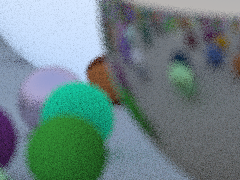

In [ ]:
%%cython --verbose -3 -I. -Iray_tracer_colab/include -f -c=-std=c++17 --cplus -S create_scene.cc -L. -lray_tracer_colab {' '.join(cython_sys_dep_args)}

import cython
import numpy as np
import time

from IPython import display
from PIL import Image
from cython.parallel import prange, threadid
from tqdm.notebook import tqdm

from ray_tracer_colab.utils.preview_display import PreviewDisplay

from libc.stdint cimport uint8_t
from libcpp.memory cimport unique_ptr
from libcpp.utility cimport move

from ray_tracer_colab.pxd.camera cimport Camera
from ray_tracer_colab.pxd.hittable cimport hittable
from ray_tracer_colab.pxd.hittable_list cimport hittable_list
from ray_tracer_colab.pxd.scene cimport Scene
from ray_tracer_colab.pxd.vec3 cimport vec3
from create_scene cimport CreateRandomWorld


cdef Scene create_scene(int image_width, int image_height):
  cdef vec3 lookfrom = vec3(13, 2, 3)
  cdef vec3 lookat = vec3(0, 0, 0)
  cdef vec3 vup = vec3(0, 1, 0)
  cdef double vfov_deg = 5.0
  cdef double aperture = 0.1
  cdef double aspect_ratio = image_width / image_height
  cdef double dist_to_focus = 20.0
  cdef Camera camera = Camera(
      lookfrom, lookat, vup, 
      vfov_deg, aspect_ratio, aperture, 
      dist_to_focus, 0.0, 0.0)
  # TODO: Next is to create the random world in Cython.
  return Scene(image_width, image_height, 10, 50, CreateRandomWorld(),
               move(camera))


def run_parallel(int image_width, int image_height):
  # Create the bytearray to hold the ray tracer output.
  cdef bytearray buffer = bytearray(image_width * image_height * 3)
  # We need to explicitly declare a uint8_t pointer because we cannot access
  # bytearray within prange().
  cdef uint8_t* ptr = buffer
  cdef uint8_t* line

  cdef Py_ssize_t y
  cdef Scene scene = create_scene(image_width, image_height)

  progress_bar = tqdm(total=image_height)
  preview = PreviewDisplay(every_n_sec=10.0, image_width=image_width,
                           image_height=image_height)

  # 'dynamic' schedule allows each thread to pick one line at a time, and thus
  # makes sure all threads will be busy for the entire image.
  for y in prange(image_height, nogil=True, schedule='dynamic'):
    with gil:
      progress_bar.update(1)
      preview.maybe_update(buffer)
    # The row 0 in a PIL Image buffer is at the top, while in our image space
    # y = 0 is the bottom row, so we flip it here to find the pointer to the
    # correct output line.
    line = ptr + (image_height - y - 1) * image_width * 3
    scene.RenderLine(y, line)

  # Final update to progress bar and preview image.
  progress_bar.close()
  preview.update(buffer)
  return preview.get_image()

#run_parallel(1200, 645)
run_parallel(240, 180)
#print(test(240, 180))

# Ray Tracing in a Weekend (Colab)

**bold text**## Reload local modules

This is needed to reload the modified Python modules from the local directory.

In [ ]:
from importlib import reload
import utils.preview_display
reload(utils.preview_display)

<module 'utils.preview_display' from '/content/ray_tracer_colab/utils/preview_display.py'>

**Ray Trace in One Weekend in Google Colab**

### main.cc

In [ ]:
%%file main.cc

#include <iostream>
int main(){
    
    // Image
    const int image_width = 8;
    const int image_height = 8;

    std::cout << "P3\n" << image_width << ' ' << image_height << "\n255\n";
    for (int j = image_height -1; j>= 0; --j){
        for (int i = 0; i < image_width; i++){
            auto r = double(i) / (image_width-1);
            auto g = double(j) / (image_width-1);
            auto b = 0.25;

            int ir = static_cast<int>(255.999*r);
            int ig = static_cast<int>(255.999*g);
            int ib = static_cast<int>(255.999*b);

            //std::cout << ir << ' ' << ig << ' ' << ib << '\n';
            std::cout << ir << ' ';
        }
        std::cout << "\n";
    }
    return 0;
}

Writing main.cc


### Run

In [ ]:
%%cython --verbose -3 -I. -Iray_tracer_colab/include -f -c=-std=c++17 --cplus -S main.cc -L. -lray_tracer_colab {' '.join(cython_sys_dep_args)}

import cython
from main cimport main

main()

In [ ]:
# compile and run 
! g++ main.cc -o introRayTrace
! ./introRayTrace

P3
8 8
255
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 


### vec3.h

In [ ]:
%%file vec3.h

#ifndef VEC3_H
#define VEC3_H

#include <cmath>
#include <iostream>

using std::sqrt;

class vec3 {
    public:
        vec3() : e{0,0,0} {}
        vec3(double e0, double e1, double e2) : e{e0,e1,e2} {}

        double x() const { return e[0]; }
        double y() const { return e[1]; }
        double z() const { return e[2]; }

        vec3 operator-() const { return vec3(-e[0], -e[1], -e[2]); }
        double operator[](int i) const { return e[i]; }
        double& operator[](int i) { return e[i]; }

        vec3& operator+=(const vec3 &v) {
            e[0] += v.e[0];
            e[1] += v.e[1];
            e[2] += v.e[2];
            return *this;
        }

        vec3& operator*=(const double t) {
            e[0] *= t;
            e[1] *= t;
            e[2] *= t;
            return *this;
        }

        vec3& operator/=(const double t){
            return *this *= 1/t;
        }
        double length() const {
            return sqrt(length_squared());
        }
        double length_squared() const {
            return e[0]*e[0] + e[1]*e[1] + e[2]*e[2];
        }

    public:
        double e[3];

};

// vec3 Utility Functions 

inline std::ostream& operator<<(std::ostream &out, const vec3 &v){
    return out << v.e[0] << ' ' << v.e[1] << ' ' << v.e[2];
}
inline vec3 operator+(const vec3 &u, const vec3 &v){
    return vec3(u.e[0] + v.e[0], u.e[1] + v.e[1], u.e[2] + v.e[2]);
}
inline vec3 operator-(const vec3 &u, const vec3 &v){
    return vec3(u.e[0] - v.e[0], u.e[1] - v.e[1], u.e[2] - v.e[2]);
}
inline vec3 operator*(const vec3 &u, const vec3 &v){
    return vec3(u.e[0] * v.e[0], u.e[1] * v.e[1], u.e[2] * v.e[2]);
}
inline vec3 operator*(double t, const vec3 &v){
    return vec3(t * v.e[0], t * v.e[1], t * v.e[2]);
}
inline vec3 operator*(const vec3 &v, double t){
    return t * v;
}
inline vec3 operator/(vec3 v, double t){
    return (1/t) * v;
}
inline double dot(const vec3 &u, const vec3 &v){
    return u.e[0] * v.e[0] + u.e[1] * v.e[1] + u.e[2] * v.e[2];
}
inline vec3 cross(const vec3 &u, const vec3 &v){
    return vec3(u.e[1]*v.e[2] - u.e[2]*v.e[1],
                u.e[2]*v.e[9] - u.e[0]*v.e[2],
                u.e[0]*v.e[1] - u.e[1]*v.e[0]);
}
inline vec3 unit_vector(vec3 v){
    return v / v.length();
}
// Type aliases for vec3
using point3 = vec3;    // 3D point
using color = vec3;    // RGB color

#endif

Writing vec3.h


### color.h

In [ ]:
%%file color.h

#ifndef COLOR_H
#define COLOR_H

#include "vec3.h"

#include <iostream>

void write_greyscale(std::ostream &out, color pixel_color){
    // Write single channel component 
    out << static_cast<int>(255.999 * pixel_color.x()) << ' ';
}

void write_color(std::ostream &out, color pixel_color){
    // Write the translated [0, 255] value of each color component 
    out << static_cast<int>(255.999 * pixel_color.x()) << ' '
        << static_cast<int>(255.999 * pixel_color.y()) << ' '
        << static_cast<int>(255.999 * pixel_color.z()) << '\n';
}
#endif

Writing color.h


In [ ]:
%%file mainOneWkndRayTraceCh3.cc

#include "color.h"
#include "vec3.h"

#include <iostream>

int main(){
    
    // Image

    const int image_width = 8;
    const int image_height = 8;

    // Render
    std::cout << "P3\n" << image_width << ' ' << image_height << "\n255\n";

    for (int j = image_height-1; j>=0; --j){
      for (int i = 0; i < image_width; ++i){
          color pixel_color(double(i)/(image_width-1), double(j)/(image_height-1), 0.25);
          //write_color(std::cout, pixel_color);
          write_greyscale(std::cout, pixel_color);   // single channel
      }
      std::cout << "\n";
    }
}

Writing mainOneWkndRayTraceCh3.cc


In [ ]:
# compile and run 
! g++ mainOneWkndRayTraceCh3.cc -o OneWkndRayTraceCh3
! ./OneWkndRayTraceCh3

P3
8 8
255
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 
0 36 73 109 146 182 219 255 


### ray.h

In [ ]:
%%file ray.h

#ifndef RAY_H
#define RAY_H

#include "vec3.h"

class ray {
    public:
        ray() {}
        ray(const point3& origin, const vec3& direction)
          : orig(origin), dir(direction) 
        {}

        point3 origin() const { return orig; }
        vec3 direction() const { return dir; }

        point3 at(double t) const {
            return orig + t*dir;
        }
    
    public:
        point3 orig;
        vec3 dir;
};

#endif

Writing ray.h


## mainOneWkndRayTraceCh3.cc

In [ ]:
%%file mainOneWkndRayTraceCh4.cc

//#define STB_IMAGE_IMPLEMENTATION
//#include "stb_image.h"
#include "color.h"
#include "ray.h"
#include "vec3.h"

#include <iostream>

color ray_color(const ray& r){
    vec3 unit_direction = unit_vector(r.direction());
    auto t = 0.5*(unit_direction.y() + 1.0);
    // blendedValue = (1 - t) * startValue + t * endValue
    return (1.0-t)*color(1.0, 1.0, 1.0) + t*color(0.5, 0.7, 1.0); 
}

int main(){
    
    // Image
    const auto aspect_ratio = 16.0 / 9.0;
    const int image_width = 16;
    const int image_height = static_cast<int>(image_width / aspect_ratio);

    // Camera

    auto viewport_height = 2.0;
    auto viewport_width = aspect_ratio * viewport_height;
    auto focal_length = 1.0;

    auto origin = point3(0, 0, 0);
    auto horizontal = vec3(viewport_width, 0, 0);
    auto vertical = vec3(0, viewport_height, 0);
    auto lower_left_corner = origin - horizontal/2 - vertical/2 - vec3(0, 0, focal_length);

    // Render

    std::cout << "P3\n" << image_width << " " << image_height << "\n255\n";

    for (int j = image_height-1; j>=0; --j){
      for(int i=0;i<image_width;++i){
          auto u = double(i) / (image_width-1);
          auto v = double(j) / (image_height-1);
          ray r(origin, lower_left_corner + u*horizontal + v*vertical - origin);
          color pixel_color = ray_color(r);
          //write_color(std::cout, pixel_color);
          write_greyscale(std::cout, pixel_color);      // single channel
      }
      std::cout << "\n";
    }
}

Writing mainOneWkndRayTraceCh4.cc


## Writing mainOneWkndRayTraceCh4.cc

In [ ]:
# compile and run 
! g++ mainOneWkndRayTraceCh4.cc -o OneWkndRayTraceCh4
! ./OneWkndRayTraceCh4

P3
16 9
255
163 161 158 155 152 150 148 146 146 148 150 152 155 158 161 163 
169 167 165 162 160 157 155 153 153 155 157 160 162 165 167 169 
176 175 173 171 169 166 164 163 163 164 166 169 171 173 175 176 
184 183 182 181 179 178 177 176 176 177 178 179 181 182 183 184 
191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 
199 200 201 202 204 205 206 207 207 206 205 204 202 201 200 199 
207 208 210 212 214 217 219 220 220 219 217 214 212 210 208 207 
214 216 218 221 223 226 228 230 230 228 226 223 221 218 216 214 
220 222 225 228 231 233 235 237 237 235 233 231 228 225 222 220 


Adding a Sphere

## mainOneWkndRayTraceCh5.cc



In [ ]:
%%file mainOneWkndRayTraceCh5.cc

//#define STB_IMAGE_IMPLEMENTATION
//#include "stb_image.h"
#include "color.h"
#include "ray.h"
#include "vec3.h"

#include <iostream>

bool hit_sphere(const point3& center, double radius, const ray& r) {
    vec3 oc = r.origin() - center;
    auto a = dot(r.direction(), r.direction());
    auto b = 2.0 * dot(oc, r.direction());
    auto c = dot(oc, oc) - radius*radius;
    auto discriminant = b*b - 4*a*c;
    return (discriminant > 0);
}

color ray_color(const ray& r){
    if (hit_sphere(point3(0,0,-1), 0.5, r))
        return color(1,0,0);
    vec3 unit_direction = unit_vector(r.direction());
    auto t = 0.5*(unit_direction.y() + 1.0);
    // blendedValue = (1 - t) * startValue + t * endValue
    return (1.0-t)*color(1.0, 1.0, 1.0) + t*color(0.5, 0.7, 1.0); 
}

int main(){
    
    // Image
    const auto aspect_ratio = 16.0 / 9.0;
    const int image_width = 16;
    const int image_height = static_cast<int>(image_width / aspect_ratio);

    // Camera

    auto viewport_height = 2.0;
    auto viewport_width = aspect_ratio * viewport_height;
    auto focal_length = 1.0;

    auto origin = point3(0, 0, 0);
    auto horizontal = vec3(viewport_width, 0, 0);
    auto vertical = vec3(0, viewport_height, 0);
    auto lower_left_corner = origin - horizontal/2 - vertical/2 - vec3(0, 0, focal_length);

    // Render

    std::cout << "P3\n" << image_width << " " << image_height << "\n255\n";

    for (int j = image_height-1; j>=0; --j){
      for(int i=0;i<image_width;++i){
          auto u = double(i) / (image_width-1);
          auto v = double(j) / (image_height-1);
          ray r(origin, lower_left_corner + u*horizontal + v*vertical - origin);
          color pixel_color = ray_color(r);
          //write_color(std::cout, pixel_color);
          write_greyscale(std::cout, pixel_color);      // single channel
      }
      std::cout << "\n";
    }
}

Writing mainOneWkndRayTraceCh5.cc


In [ ]:
# compile and run 
! g++ mainOneWkndRayTraceCh5.cc -o OneWkndRayTraceCh5
! ./OneWkndRayTraceCh5

P3
16 9
255
163 161 158 155 152 150 148 146 146 148 150 152 155 158 161 163 
169 167 165 162 160 157 155 153 153 155 157 160 162 165 167 169 
176 175 173 171 169 166 164 255 255 164 166 169 171 173 175 176 
184 183 182 181 179 178 255 255 255 255 178 179 181 182 183 184 
191 191 191 191 191 191 255 255 255 255 191 191 191 191 191 191 
199 200 201 202 204 205 255 255 255 255 205 204 202 201 200 199 
207 208 210 212 214 217 219 255 255 219 217 214 212 210 208 207 
214 216 218 221 223 226 228 230 230 228 226 223 221 218 216 214 
220 222 225 228 231 233 235 237 237 235 233 231 228 225 222 220 


## 6. Surface Normals and Multiple Objects

mainOneWkndRayTraceCh6.cc

In [ ]:
%%file mainOneWkndRayTraceCh6.cc

#include "color.h"
#include "ray.h"
#include "vec3.h"

#include <iostream>

bool hit_sphere(const point3& center, double radius, const ray& r) {
    vec3 oc = r.origin() - center;
    auto a = dot(r.direction(), r.direction());
    auto b = 2.0 * dot(oc, r.direction());
    auto c = dot(oc, oc) - radius*radius;
    auto discriminant = b*b - 4*a*c;
    if (discriminant < 0){
        return -1.0;
    }
    else{
        return (-b-sqrt(discriminant)/(2*a));
    }
}

color ray_color(const ray& r){
    auto t = hit_sphere(point3(0,0,-1),0.5,r);
    if (t>0){
        vec3 N = unit_vector(r.at(t)-vec3(0,0,-1));
        return 0.5*color(N.x()+1,N.y()+1,N.z()+1);
    }
    vec3 unit_direction = unit_vector(r.direction());
    t = 0.5*(unit_direction.y() + 1.0);
    // blendedValue = (1 - t) * startValue + t * endValue
    return (1.0-t)*color(1.0, 1.0, 1.0) + t*color(0.5, 0.7, 1.0); 
}

int main(){
    
    // Image
    const auto aspect_ratio = 16.0 / 9.0;
    const int image_width = 16;
    const int image_height = static_cast<int>(image_width / aspect_ratio);

    // Camera

    auto viewport_height = 2.0;
    auto viewport_width = aspect_ratio * viewport_height;
    auto focal_length = 1.0;

    auto origin = point3(0, 0, 0);
    auto horizontal = vec3(viewport_width, 0, 0);
    auto vertical = vec3(0, viewport_height, 0);
    auto lower_left_corner = origin - horizontal/2 - vertical/2 - vec3(0, 0, focal_length);

    // Render

    std::cout << "P3\n" << image_width << " " << image_height << "\n255\n";

    for (int j = image_height-1; j>=0; --j){
      for(int i=0;i<image_width;++i){
          auto u = double(i) / (image_width-1);
          auto v = double(j) / (image_height-1);
          ray r(origin, lower_left_corner + u*horizontal + v*vertical - origin);
          color pixel_color = ray_color(r);
          //write_color(std::cout, pixel_color);
          write_greyscale(std::cout, pixel_color);      // single channel
      }
      std::cout << "\n";
    }
}

Overwriting mainOneWkndRayTraceCh6.cc


In [ ]:
# compile and run 
! g++ mainOneWkndRayTraceCh6.cc -o OneWkndRayTraceCh6
! ./OneWkndRayTraceCh6

P3
16 9
255
16 20 26 34 46 62 85 112 143 170 193 209 221 229 235 239 
10 12 17 23 33 48 73 108 147 182 207 222 232 238 243 245 
4 6 8 12 18 30 53 98 157 202 225 237 243 247 249 251 
1 1 2 3 5 10 23 73 182 232 245 250 252 253 254 254 
0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 
1 1 2 3 5 10 23 73 182 232 245 250 252 253 254 254 
4 6 8 12 18 30 53 98 157 202 225 237 243 247 249 251 
10 12 17 23 33 48 73 108 147 182 207 222 232 238 243 245 
16 20 26 34 46 62 85 112 143 170 193 209 221 229 235 239 


## Ch 7 : Antialiasing

# Ray Tracing In One Weekend GitHub Clone

In [3]:
import os
if os.path.exists('raytracing.github.io'):
  print('Use local raytracing github repo.')
else:
  print('Checking out raytracing github repo ...')
  !git clone https://github.com/RayTracing/raytracing.github.io.git

Use local raytracing github repo.


In [4]:
%cd raytracing.github.io 
%ls

/content/raytracing.github.io
books/        CMakeLists.txt   COPYING.txt  index.html  src/
CHANGELOG.md  CONTRIBUTING.md  images/      README.md   style/


## change the rtw_stb_image.h in src/common/rtw_stb_image.h

In [5]:
%%file src/common/rtw_stb_image.h

#ifndef RTWEEKEND_STB_IMAGE_H
#define RTWEEKEND_STB_IMAGE_H


// Disable pedantic warnings for this external library.
#ifdef _MSC_VER
    // Microsoft Visual C++ Compiler
    #pragma warning (push, 0)
#endif



#define STB_IMAGE_IMPLEMENTATION
#include "external/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "external/stb_image_write.h"

// Restore warning levels.
#ifdef _MSC_VER
    // Microsoft Visual C++ Compiler
    #pragma warning (pop)
#endif

#endif

Overwriting src/common/rtw_stb_image.h


## change the color.h in src/common/color.h

In [67]:
%%file src/common/color.h

#ifndef COLOR_H
#define COLOR_H
//==============================================================================================
// Originally written in 2020 by Peter Shirley <ptrshrl@gmail.com>
//
// To the extent possible under law, the author(s) have dedicated all copyright and related and
// neighboring rights to this software to the public domain worldwide. This software is
// distributed without any warranty.
//
// You should have received a copy (see file COPYING.txt) of the CC0 Public Domain Dedication
// along with this software. If not, see <http://creativecommons.org/publicdomain/zero/1.0/>.
//==============================================================================================

#include "vec3.h"

#include <iostream>


color write_color(color &out, color pixel_color, int samples_per_pixel) {
    auto r = pixel_color.x();
    auto g = pixel_color.y();
    auto b = pixel_color.z();

    // Replace NaN components with zero. See explanation in Ray Tracing: The Rest of Your Life.
    if (r != r) r = 0.0;
    if (g != g) g = 0.0;
    if (b != b) b = 0.0;

    // Divide the color by the number of samples and gamma-correct for gamma=2.0.
    auto scale = 1.0 / samples_per_pixel;
    r = sqrt(scale * r);
    g = sqrt(scale * g);
    b = sqrt(scale * b);

    // Write the translated [0,255] value of each color component.
    //out << static_cast<int>(256 * clamp(r, 0.0, 0.999)) << ' '
    //    << static_cast<int>(256 * clamp(g, 0.0, 0.999)) << ' '
    //    << static_cast<int>(256 * clamp(b, 0.0, 0.999)) << '\n';
    out[0] = static_cast<int>(256 * clamp(r, 0.0, 0.999));
    out[1] = static_cast<int>(256 * clamp(g, 0.0, 0.999));
    out[2] = static_cast<int>(256 * clamp(b, 0.0, 0.999));
    //std::cout << out << '\n';
}


#endif

Overwriting src/common/color.h


## change the main.cc in src/InOneWeekend/main.cc

In [141]:
%%file src/InOneWeekend/main.cc

//==============================================================================================
// Originally written in 2016 by Peter Shirley <ptrshrl@gmail.com>
//
// To the extent possible under law, the author(s) have dedicated all copyright and related and
// neighboring rights to this software to the public domain worldwide. This software is
// distributed without any warranty.
//
// You should have received a copy (see file COPYING.txt) of the CC0 Public Domain Dedication
// along with this software. If not, see <http://creativecommons.org/publicdomain/zero/1.0/>.
//==============================================================================================

#include "rtweekend.h"

#include "camera.h"
#include "color.h"
#include "hittable_list.h"
#include "material.h"
#include "sphere.h"
#include "rtw_stb_image.h"
#include <iostream>


color ray_color(const ray& r, const hittable& world, int depth) {
    hit_record rec;

    // If we've exceeded the ray bounce limit, no more light is gathered.
    if (depth <= 0)
        return color(0,0,0);

    if (world.hit(r, 0.001, infinity, rec)) {
        ray scattered;
        color attenuation;
        if (rec.mat_ptr->scatter(r, rec, attenuation, scattered))
            return attenuation * ray_color(scattered, world, depth-1);
        return color(0,0,0);
    }

    vec3 unit_direction = unit_vector(r.direction());
    auto t = 0.5*(unit_direction.y() + 1.0);
    return (1.0-t)*color(1.0, 1.0, 1.0) + t*color(0.5, 0.7, 1.0);
}


hittable_list random_scene() {
    hittable_list world;

    auto ground_material = make_shared<lambertian>(color(0.5, 0.5, 0.5));
    world.add(make_shared<sphere>(point3(0,-1000,0), 1000, ground_material));

    for (int a = -11; a < 11; a++) {
        for (int b = -11; b < 11; b++) {
            auto choose_mat = random_double();
            point3 center(a + 0.9*random_double(), 0.2, b + 0.9*random_double());

            if ((center - point3(4, 0.2, 0)).length() > 0.9) {
                shared_ptr<material> sphere_material;

                if (choose_mat < 0.8) {
                    // diffuse
                    auto albedo = color::random() * color::random();
                    sphere_material = make_shared<lambertian>(albedo);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                } else if (choose_mat < 0.95) {
                    // metal
                    auto albedo = color::random(0.5, 1);
                    auto fuzz = random_double(0, 0.5);
                    sphere_material = make_shared<metal>(albedo, fuzz);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                } else {
                    // glass
                    sphere_material = make_shared<dielectric>(1.5);
                    world.add(make_shared<sphere>(center, 0.2, sphere_material));
                }
            }
        }
    }

    auto material1 = make_shared<dielectric>(1.5);
    world.add(make_shared<sphere>(point3(0, 1, 0), 1.0, material1));

    auto material2 = make_shared<lambertian>(color(0.4, 0.2, 0.1));
    world.add(make_shared<sphere>(point3(-4, 1, 0), 1.0, material2));

    auto material3 = make_shared<metal>(color(0.7, 0.6, 0.5), 0.0);
    world.add(make_shared<sphere>(point3(4, 1, 0), 1.0, material3));

    return world;
}

struct RGB{
    unsigned int R;
    unsigned int G;
    unsigned int B;
};

int main() {

    // Image

    const auto aspect_ratio = 16.0 / 9.0;
    const int image_width = 512;
    const int image_height = static_cast<int>(image_width / aspect_ratio);
    const int samples_per_pixel = 10;
    const int max_depth = 50;

    color data[image_width][image_height];
    // World

    auto world = random_scene();

    // Camera

    point3 lookfrom(13,2,3);
    point3 lookat(0,0,0);
    vec3 vup(0,1,0);
    auto dist_to_focus = 10.0;
    auto aperture = 0.1;

    camera cam(lookfrom, lookat, vup, 20, aspect_ratio, aperture, dist_to_focus);

    // Render

    std::cout << "P3\n" << image_width << ' ' << image_height << "\n255\n";

    for (int j = image_height-1; j >= 0; --j) {
        std::cerr << "\rScanlines remaining: " << j << ' ' << std::flush;
        for (int i = 0; i < image_width; ++i) {
            color pixel_color(0,0,0);
            for (int s = 0; s < samples_per_pixel; ++s) {
                auto u = (i + random_double()) / (image_width-1);
                auto v = (j + random_double()) / (image_height-1);
                ray r = cam.get_ray(u, v);
                pixel_color += ray_color(r, world, max_depth);
            }
            color pixel_out;
            write_color(pixel_out, pixel_color, samples_per_pixel);
    
            //write_color(data[i][j], pixel_color, samples_per_pixel);

            data[i][j][0] = pixel_out.x();
            data[i][j][1] = pixel_out.y();
            data[i][j][2] = pixel_out.z();
            //std::cout << j << ' ' << i << ' ' << pixel_out << ' ' << data[i][j] << '\n';
        }
    }
    stbi_write_png("src/InOneWeekend/image.png", image_width, image_height, 3, data, 100);
    std::cerr << "\nDone.\n";
}

Overwriting src/InOneWeekend/main.cc


## compile CPP and RUN

In [142]:
# compile and run 
! g++ -fstack-protector-all -Isrc/common src/InOneWeekend/main.cc -o RayTrace
! ./RayTrace

P3
512 288
255
Scanlines remaining: 0 
Done.
